<a href="https://colab.research.google.com/github/willystw/fastai-learning/blob/gru-implementation/gru-architecture/GRU_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 12.2 MB/s 
     |████████████████████████████████| 186 kB 51.8 MB/s 
     |████████████████████████████████| 1.2 MB 45.4 MB/s 
     |████████████████████████████████| 46 kB 3.4 MB/s 
     |████████████████████████████████| 56 kB 4.2 MB/s 
     |████████████████████████████████| 51 kB 315 kB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *

Implement Gated Recurrent Unit

In [3]:
from IPython.display import SVG
def show_svg():
    display(SVG(url='https://upload.wikimedia.org/wikipedia/commons/3/37/Gated_Recurrent_Unit%2C_base_type.svg'))

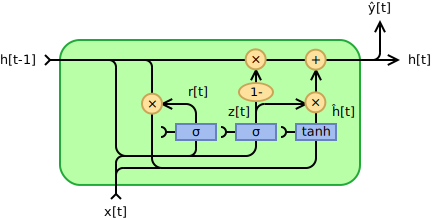

In [4]:
show_svg()

In [5]:
class GRUImpl(Module):
  def __init__(self, ni, nh):
    self.reset_gate = nn.Linear(ni+nh, nh)
    self.update_gate = nn.Linear(ni+nh, nh)

  def forward(self, input, state):
    h,_ = state
    h_1 = torch.cat([h, input], dim = 1)
    reset = torch.sigmoid(self.reset_gate(h_1))
    update = torch.sigmoid(self.update_gate(h_1))
    h_2 = torch.cat([reset * h, input], dim = 1)
    
    out = torch.tanh(h_2)
    h *= (1 - update)
    h += (activation * update)

    return h

Simplified version to do one big matrix operation

In [6]:
class GRUImpl(Module):
  def __init__(self, ni, nh):
    self.ih = nn.Linear(ni, 2*nh)
    self.hh = nn.Linear(nh, 2*nh)
  def forward(self, input, state):
    h = state
    gates = (self.ih(input) + self.hh(h)).chunk(2,1)
    resetgate, updategate = map(torch.sigmoid, gates[:2])

    out = torch.tanh(torch.cat([resetgate * h, input], dim = 1))
    h *= (1 - updategate)
    h += (out * updategate)

    return h

Test LSTM & GRU using Human Numbers Datasest

In [7]:
from fastai.text.all import *
path = untar_data(URLs.HUMAN_NUMBERS)

In [8]:
#hide
Path.BASE_PATH = path

In [9]:
path.ls()

(#2) [Path('valid.txt'),Path('train.txt')]

Human numbers dataset contains number from 1 to 9999 in text form, and separated with dot ('.')

In [10]:
lines = L()
with open(path/'train.txt') as f: lines += L(*f.readlines())
with open(path/'valid.txt') as f: lines += L(*f.readlines())
lines

(#9998) ['one \n','two \n','three \n','four \n','five \n','six \n','seven \n','eight \n','nine \n','ten \n'...]

In [13]:
text = ' . '.join([l.strip() for l in lines])
text[-100:]

'dred ninety seven . nine thousand nine hundred ninety eight . nine thousand nine hundred ninety nine'

In [68]:
text[:100]

'one . two . three . four . five . six . seven . eight . nine . ten . eleven . twelve . thirteen . fo'

In [15]:
tokens = text.split(' ')
tokens[-10:]

['hundred',
 'ninety',
 'eight',
 '.',
 'nine',
 'thousand',
 'nine',
 'hundred',
 'ninety',
 'nine']

In [16]:
vocab = L(*tokens).unique()
vocab

(#30) ['one','.','two','three','four','five','six','seven','eight','nine'...]

In [17]:
word2idx = {w:i for i,w in enumerate(vocab)}
nums = L(word2idx[i] for i in tokens)
nums

(#63095) [0,1,2,1,3,1,4,1,5,1...]

In [18]:
seqs = L((tensor(nums[i:i+3]), nums[i+3]) for i in range(0,len(nums)-4,3))
seqs

(#21031) [(tensor([0, 1, 2]), 1),(tensor([1, 3, 1]), 4),(tensor([4, 1, 5]), 1),(tensor([1, 6, 1]), 7),(tensor([7, 1, 8]), 1),(tensor([1, 9, 1]), 10),(tensor([10,  1, 11]), 1),(tensor([ 1, 12,  1]), 13),(tensor([13,  1, 14]), 1),(tensor([ 1, 15,  1]), 16)...]

In [25]:
def group_chunks(ds, bs):
    m = len(ds) // bs
    new_ds = L()
    for i in range(m): new_ds += L(ds[i + m*j] for j in range(bs))
    return new_ds

In [52]:
bs = 64
sl = 16
seqs = L((tensor(nums[i:i+sl]), tensor(nums[i+1:i+sl+1]))
         for i in range(0,len(nums)-sl-1,sl))
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(group_chunks(seqs[:cut], bs),
                             group_chunks(seqs[cut:], bs),
                             bs=bs, drop_last=True, shuffle=False)

In [34]:
[L(vocab[o] for o in s) for s in seqs[0]]

[(#16) ['one','.','two','.','three','.','four','.','five','.'...],
 (#16) ['.','two','.','three','.','four','.','five','.','six'...]]

Create 2 layers of language model using GRU

In [63]:
#Dropout is a technique that randomly change some activations to zero
class LMModelGRU(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers, drop_prob=0.2):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.GRU(n_hidden, n_hidden, n_layers, batch_first=True, dropout=drop_prob)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(n_layers, bs, n_hidden)
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(res)
    
    def reset(self): 
        self.h.zero_()

In [70]:
learn = Learner(dls, LMModelGRU(len(vocab), 64, 2, 0.4), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 1e-2, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,2.861346,2.467577,0.436768,00:01
1,2.001540,1.900322,0.389893,00:01
2,1.608183,1.681775,0.458903,00:01
3,1.303667,1.817880,0.547282,00:01
4,0.955920,1.617195,0.660156,00:01
5,0.642353,1.451181,0.739502,00:02
6,0.415039,1.283370,0.766927,00:01
7,0.272555,1.210567,0.804525,00:01
8,0.182805,1.258596,0.813802,00:01
9,0.123646,1.198145,0.825521,00:01


Comparison with using LSTM

In [65]:
class LMModelLSTM(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers, drop_prob=0.2):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True, dropout=drop_prob)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)
    
    def reset(self): 
        for h in self.h: h.zero_()

In [66]:
learn = Learner(dls, LMModelLSTM(len(vocab), 64, 2, 0.4), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 1e-2, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.011736,2.735395,0.274333,00:01
1,2.237267,2.028148,0.274414,00:01
2,1.683535,1.702606,0.465251,00:01
3,1.412406,1.683675,0.486572,00:01
4,1.196439,1.715379,0.541178,00:01
5,0.948837,1.705389,0.625977,00:01
6,0.743227,1.578199,0.707113,00:01
7,0.550748,1.382865,0.747314,00:01
8,0.409136,1.231079,0.753174,00:01
9,0.314691,1.240279,0.767904,00:01


It is shown that GRU has better result than LSTM method